# **This is a notebook to analyze the effect of Wall Street Bets (WSB) sentiment on stock price **
## Quick start. 
to just test notebook, run all
experiment with what if go to Step 9. 
(note will add more descriptive info for the Basic Algo and What ifs)
## You will need the following files in your directory
<ol>
<li>wsb_pushshift_data.csv</li>
<li>test1.env
</ol>

## Basic Algorithm:
<ol>
<li>Read Data from CSV of WSB</li>
<li>Read stock price Data from Alpaca</li>
<li>Create dataframe for machine learning</li>
<li>Run parmaeterized machine learning</li>
</ol>

## To do what ifs (Step 9):
<ol>
<li>you can analyze sentiments from different stocks</li>
<li>run different machine learning models</li> 
</ol>

## Step 1 Set up 

In [1]:
import os
import re
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from datetime import date, datetime
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
from scipy import stats
from nltk.corpus import stopwords
from collections import Counter

In [2]:
# additional imports
import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import datetime
import time
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
# from datetime import date, datetime
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\big_j\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
from sklearn.preprocessing import MinMaxScaler

In [4]:
# Import required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [5]:
from alpaca_trade_api.rest import TimeFrame

In [6]:
def word_count(df):
    """
    This function takes the dataframe and adds a new colun with the number of words.
    :param df: The dataframe to be transformed.
    :return: The transformed dataframe.
    """
    words_count = []
    for i, content in df['title'].items():
        new_values =[]
        new_values = content.split()
        words_count.append(len(new_values))
    df['title_word_count'] = words_count
    return df


#### 1.5 Clean Dataframe

In [7]:
def clean_data(in_df):
    '''
    #clean data and return a "standrd form"
    # input input data frame as describe above
    # output: cleand data frame
    '''
    from datetime import date, datetime # get librareis
    df = in_df.copy() # make a copy
    #df = df.drop(columns=['id', 'url', 'created']) # drop unused columns remove v 3.8
    
    #add date and time
    year_col = []
    month_col = []
    hour_col = []
    minute_col = []
    day_col = [] # v 1.6 add day colummn
    date_col = [] #
    for i, content in df['timestamp'].items():
        t1 = datetime.strptime(content, '%Y-%m-%d %H:%M:%S')
        year_col.append(t1.year)
        month_col.append(t1.month)
        hour_col.append(t1.hour)
        minute_col.append(t1.minute)
        day_col.append(t1.day) #v 1.6 add day column
        date_col.append(t1.date())
    df['year'] = year_col
    df['month'] = month_col
    df['hour'] = hour_col
    df['minute'] = minute_col 
    df['day'] = day_col # v 1.6 add day col
    df['date'] = date_col
    
    #Normalize the text to be lowercase
    df['title'] = df['title'].str.lower()
    df['body'] = df['body'].str.lower()
    df.drop_duplicates(subset=['title'], keep='first', inplace=True)

    #Count the number of characters and length of a title
    df = word_count(df)
    df['title_length'] = df['title'].str.len()
    
    #return value
    return df

## Step 2, Combine Title and Body (start of new code)

#### 2.1 combine title and body in to one column

In [8]:
def combine_columns(in_df, in_col1, in_col2):
    '''
    #combine two columns into one
    #convert columns to text and concat
    #input:
    #in_df - datafraem
    #in_col1 - name of column 1
    #in_col2 - name of column 2
    #return data_frame with extract column
    '''
#     # make a copy so original is not damanged and drop where there is no text in title or body

    # convertitle and body to string and concaterante
    new_df = in_df.copy()
    new_df [in_col1 + '_' + in_col2] = in_df[in_col1].astype(str) + ' ' + in_df [in_col2].astype(str)
    return new_df


#### 2.2 routine to do count of ticker.

In [9]:
def find_comment_count(in_df, in_word_list, in_column): 
    '''
    # purpose: finds count of words in a column and creates named coumns with counts
    #inputs: 
    #in_df - input dataframe 
    #in_word_list list of words to find
    #in_column the column in which the wordsare
    #output:
    #a copy of the original data with columns added for word count
    '''
    #code here
    #put in error handler
    try:
        tmp_df = in_df.copy() #make a copy of the dataframe
        tmp_df [in_column] = tmp_df [in_column].astype(str) # convrt to string
        srch_word_list = [str(x) for x in in_word_list] #convert everthing words list to string
        #wordList = re.sub("[^\w]", " ",  mystr).split()
        tmp_df[in_column + '_list'] = tmp_df[in_column].apply (lambda x: re.sub("[^\w]", " ",  x).split()) # convert into a list of words
        
        # loop through list of words and create counts
        for cur_word in srch_word_list:
            # v 1.8 dont look at list,  look in original column with 
            #tmp_df [cur_word + '_count'] = tmp_df[in_column + '_list'].apply(lambda x: x.count(cur_word))
            lower_word = cur_word.lower()# v 1.8
            tmp_df [cur_word + '_count'] = tmp_df[in_column].apply(lambda x: x.count(lower_word)) # v 1.8
        return tmp_df
        
    except:
        #if eror then return null
        return  
        

## Step 3 Get emotions from each combined message

### 3.1 function to add vader emotion to each message

In [10]:
# function to calculate vader sentiment
def add_vader_compound(in_df, in_column, in_tick_mention, in_tick):
    '''
    #take and input column, add vader sentiment
    # input:
    # in_df  - put put df
    # in_column - text for which 
    # in_tick_mention - number of times ticker 
    # in_tick - name for the ticke
    #output:
    #df with two addition coumnns
    #additional col1 = in_column + '_sent' - sentiment for the in_column
    #           cik2 = in_tick_sent - sentiment where ticker is mentioned
    
    
    
    # make sure nltk and vader is downloaded 
    # if not downloaded, uncomment and download
    # Download/Update the VADER Lexicon
    #nltk.download('vader_lexicon')
    #from nltk.sentiment.vader import SentimentIntensityAnalyzer
    # Initialize the VADER sentiment analyzer
    # analyzer = SentimentIntensityAnalyzer()
    '''
    
#     nltk.download('vader_lexicon')


    try:
        tmp_df = in_df.copy() #make a copy of the dataframe
        tmp_df [in_column] = tmp_df [in_column].astype(str) # convrt to string
        analyzer = SentimentIntensityAnalyzer() # set analyzer
        #total sentiment
        tot_sent = in_column + '_sent'
        tmp_df[tot_sent] = tmp_df [in_column].apply (lambda x: analyzer.polarity_scores(x)['compound'])
        #sentiment on ticker mention
        tmp_df[in_tick + '_sent'] = tmp_df.apply(lambda x: x[in_tick_mention] if x[in_tick_mention] == 0 else x[tot_sent], axis = 1)
            
        return tmp_df
        
    except:
         #if eror then return null
         print ('error in add_vader_compound')
         return 
    

## Step 4 get stock price at that time

In [11]:
def get_prices (in_tick, in_strt_date, in_end_date,in_timeframe, in_env_path):
    '''
    # return a dataframe with stock price info from Alpaca by the minute
    # inputs:
    # in_tick - string with ticker symbol
    # in_start_date as a start date in format: beg_date = '2021-01-05'
    # in_end_date in format: end_date = '2021-01-05'
    # in_timeframe set as interval for stock price
    # in_env_path path for enviornment file
    # return:
    # data frame with stock prices.
    # To do - put output structure
    '''
    #note works for 1000 items. how to get longer times.
    from alpaca_trade_api.rest import TimeFrame
    try:
        #load environment
        load_dotenv(in_env_path)
        
        #get alpaka keys
        alpaca_api_key = os.getenv("ALPACA_API_KEY")
        alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")
#         print (f'alpaca api {alpaca_api_key}\n')
#         print (f'alpaca secret {alpaca_secret_key}\n')
        #set up alpaca
        api = tradeapi.REST(
        alpaca_api_key,
        alpaca_secret_key,
        api_version = "v2"
        )
    
        start =  pd.Timestamp(f'{in_strt_date} 09:30:00-0400', tz='America/New_York').replace(hour=9, minute=30, second=0).astimezone('GMT').isoformat()[:-6]+'Z'
        end   =  pd.Timestamp(f'{in_end_date} 16:00:00-0400', tz='America/New_York').replace(hour=16, minute=0, second=0).astimezone('GMT').isoformat()[:-6]+'Z'
#         print (f'start: {start}\n')
#         print (f'end: {end}\n')
#         prices = api.get_barset(in_tick, TimeFrame.Hours,limit=1000, start=start, end=end).df
        prices = api.get_barset(in_tick, in_timeframe,limit=1000, start=start, end=end).df
        
        #add date colum
        prices['date'] = prices.index.map(lambda x: x.date())
        
        return prices

    except:
        return null

## Step 5 combine price with data and emotion



In [12]:
def comb_sent_mention(in_df, in_tick, in_timeframe,in_start_date, in_end_date, in_env_file, in_col1, in_col2 ):
    '''
    #creates a combined data frame for a from data struct
    # input:
    # in_df = input data frame
    # in_tick =  ticker symbo
    # in_timeframe = suggest '1D'
    # in_start_date = in the form'2021-01-28'
    # in_end_date = in the form '2021-01-28'
    # in_env_file = in this case'test1.env' 
    # in_col1 = in this case 'title'
    # in_col2 = in this case 'body'   
    # output:
    # combined dta frame
    '''
#     price_df = get_prices(in_tick, in_start_date, in_end_date, in_timeframe,in_env_file) # get price from alpaa - not used here..
    df_clean = clean_data(in_df) # clean it up
    df = combine_columns(df_clean, in_col1, in_col2) # combine title and body
    comb_col_title = in_col1 + '_' + in_col2 # combine the column titles
    df = find_comment_count(df, [in_tick], comb_col_title) # find number of mentions 
    df = add_vader_compound(df, comb_col_title, in_tick + '_count', in_tick) # add emotion 2.5 updated
# test1_df = add_vader_compound(test_df, 'title_body', in_tick + '_count',in_tick)    
    #v 2.4 make column that is sentiment only if ticker is mentioend.
    # ticker _ count
    # title_body_sent
    # 
    #sum sentiment and count by day - future fix add variable length
    
    grpby_cols = ['year', 'month', 'day']
    sum_by_cols = [in_tick + '_count', comb_col_title + '_sent', in_tick + '_sent' ] # 2.5; summarize all ticker sentimetn
    
    tmp_df = df.groupby(grpby_cols)[sum_by_cols].sum().add_suffix('_sum')
    df = df.join (tmp_df, on = grpby_cols)
    
    return df
    
    

## Step 6 combine with daily price of stock.

In [13]:
def create_price_sent(in_sent_df, in_price_df, in_tick):
    '''
    #create a combined dataframe for input in to Machine Learning
    # input: 
    # in_df sentiment: datafraem
    # in_price_df;
    # in_tick: ticker symbol
    # output data frame with columsn
    # column names 
    # mentions: number of mentions
    # sentiemnt: overall sentiment for day
    # ticker_sent: sentiment for ticker
    '''
    #Step add additional info to incoming datafraem
    in_tick_count = in_tick + '_count_sum' # a sum of the counts
    in_tick_sent_sum = in_tick + '_sent_sum' # a sum of sentiment
    senti_df = in_sent_df[['date', in_tick_count, 'title_body_sent_sum', in_tick_sent_sum]].copy()
    senti_df.drop_duplicates(inplace = True)
    senti_df.rename (columns = {'GME_count_sum': 'mentions', 'title_body_sent_sum': 'sentiment', in_tick_sent_sum: 'ticker_sent' }, inplace = True)
    senti_df.set_index('date', inplace = True)
    
    #clean the price dataframe
    tmp_price_df = in_price_df [in_tick].copy()
#     print (in_tick) #debug
#     print(tmp_price_df.head(2)) #debug
    tmp_price_df['date'] = tmp_price_df.index.map(lambda x: x.date())
    tmp_price_df.reset_index(inplace = True)
    tmp_price_df.drop (columns = ['time', 'open', 'high', 'low'], inplace = True)
    tmp_price_df.set_index('date', inplace = True) 
    
    comb_df = tmp_price_df.join (senti_df, how = 'left', on = 'date') #combine the dataframes
    #joint them and return it
    zero_rng = .01 # rane for zero
    comb_df ['pct_ch'] = comb_df['close'].pct_change()
    comb_df['up_neu_dn'] = comb_df ['pct_ch'].apply (lambda x: -1 if x < -zero_rng else 1 if x > zero_rng else 0)
    comb_df.dropna(inplace = True)    
    
#     comb_df = tmp_price_df.join (senti_df, how = 'left', on = 'date')
    return comb_df

### 7.1 Fetch Data function

In [14]:
def fetch_data (in_tick, in_start_date, in_end_date):
    '''
    #create a dataframe that:
    #has sentiment from redit wsb
    #price data from Alpaca
    #input: 
    # in_tick : ticker symbo
    # start_date in form: yyyy-mm-dd
    # end_date in form: yyyy-mm-dd
    #create output data from with folloiwn columsn
    #date: index close: closing price volume:trading volume mentions: number of times ticker is mentioned 
    #sentiment: sentiment that day ticker_sent: sentiment of the ticker pct_ch: daily price percent chagne up_neu_dn: is price up down or netural
    # 
    
    #read data file
    #read alpaca file
    #combination process.
    '''
#     data_df  = pd.read_csv('./reddit_wsb.csv') #read file
    data_df  = pd.read_csv('./wsb_pushshift_data.csv')
    sent_df = comb_sent_mention(data_df, in_tick, '1D', in_start_date,in_end_date , 'test1.env' ,  'title', 'body') #create sentiment file
    price_df =  get_prices(in_tick, in_start_date, in_end_date, '1D','test1.env' ) # read prices from alpaca
    ml_df = create_price_sent(sent_df, price_df, in_tick) #create ml data frame
    ml_df.to_csv('ml_' + in_tick + '.csv')
    
    return ml_df

In [15]:
# to delete
# # sent_df.head(2)
# ml_df.head(2)

## Step 8 Start ML part

### 8.1 Function to Prep Data

In [16]:
def window_data(df, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(df) - window):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

### 8.2 LSTM ML Function

In [17]:
def run_lstm(in_df, in_feat_name, in_targ_name = 'pct_ch', in_savefname = 'out.png', in_title= 'Title'):
    '''
    #run lstm
    #input: 
    #in_df: from create_price_sent
    #in_feat_name: name of the feature
    #in_targ_name: name of target column
    #in_savefname: name of file to be saved xx.png
    # ouput
    # lstm results
    '''
    
    #get paramters for data set
    try:
       feat_col = in_df.columns.get_loc(in_feat_name)
       targ_col = in_df.columns.get_loc(in_targ_name)
    except:
        print ('invalid column name')
        return
    
    #create dataset
    win_size = 5 #to paramterize
    #feat_col = 4 #to paramterize # v 4.0
    #targ_col = 6#to paramterize v 4.0
    X, y =  window_data(in_df, win_size, feat_col, targ_col)
    
    # Use 70% of the data for training and the remainder for testing
    split = int(0.7 * len(X)) #parameterize
    X_train = X[: split]
    X_test = X[split:]
    y_train = y[: split]
    y_test = y[split:]    
    
    # Use the MinMaxScaler to scale data between 0 and 1.
    from sklearn.preprocessing import MinMaxScaler # put initintialization
    scaler = MinMaxScaler()
    scaler.fit(X)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    scaler.fit(y)
    y_train = scaler.transform(y_train)
    y_test = scaler.transform(y_test)
    
    # Reshape the features for the model
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    # Define the LSTM RNN model.
    model = Sequential()

    number_units = 5
    dropout_fraction = 0.2

    # Layer 1
    model.add(LSTM(
        units=number_units,
        return_sequences=True,
        input_shape=(X_train.shape[1], 1))
        )
    model.add(Dropout(dropout_fraction))
    # Layer 2
    model.add(LSTM(units=number_units, return_sequences=True))
    model.add(Dropout(dropout_fraction))
    # Layer 3
    model.add(LSTM(units=number_units))
    model.add(Dropout(dropout_fraction))
    # Output layer
    model.add(Dense(1))
    
    # Compile the model
    model.compile(optimizer="adam", loss="mean_squared_error")
    
    #fit the model
    model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)
    
    # Evaluate the model
    eval = model.evaluate(X_test, y_test)
    print (f'\nModel loss = {eval}\n')
    
    # Make some predictions
    predicted = model.predict(X_test)
    
    # Recover the original prices instead of the scaled version
    predicted_prices = scaler.inverse_transform(predicted)
    real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    # Create a DataFrame of Real and Predicted values
    stocks = pd.DataFrame({
        "Real": real_prices.ravel(),
        "Predicted": predicted_prices.ravel()
        }, index = in_df.index[-len(real_prices): ])
    stocks.head()
    
    # Plot the real vs predicted prices as a line chart
    
    plot = stocks.plot(figsize = (10, 5), title = in_title)
    fig = plot.get_figure()
    fig.savefig(in_savefname)
    return eval

# Step 9.0 Main
## Start with 9.1
## Run 9.2 to import data. you can v
## Run 9.3 to to run Single LSTM
## Run 9.4 to run batch LSTM

## 9.1 Run all cells above this to initiizlize


## 9.2 Fetch data with stock with start and end date
Change it to fetch different stock or range

In [18]:
ml_df = fetch_data ('GME', '2021-01-28', '2021-06-28' )

## 9.3 run LSTM the cell below if you want run one LSTM

In [19]:
# select X and y from this list of string
# ['close', 'volume', ticke + '_count_sum', 'sentiment', 'ticker_sent', 'pct_ch', 'up_neu_dn']
# for testing
# run_lstm(ml_df, 'AAPL_count_sum', 'pct_ch', 'aapl_pct_chg_mention', 'Apple % by Mention') 

## 9.4 batch run of getting a set of outputs

In [20]:
# set up... 
feat_tmplt = [ 'sentiment','ticker_sent']
tick_list = ['AAPL','GME']
targ_list = ['pct_ch', 'up_neu_dn']
count_sufx = '_count_sum'
tick_num = 1 #select GME. 
cur_tick = tick_list[tick_num] #select GME
feat_list = [cur_tick + count_sufx] + feat_tmplt
col_names = ['Ticker', 'Target', 'Feature', 'Loss']
result_df = pd.DataFrame(columns = col_names)
# targ_num  = 0
# cur_targ = targ_list[targ_num]
# file_name_prfx = cur_tick + '_' + cur_targ

In [21]:
# rum only if you want new data - takes a looooooooooooong time
# ml_df = fetch_data (cur_tick, '2021-01-28', '2021-06-28' )

invalid column name
Epoch 1/10
39/39 [==============================] - 4s 3ms/step - loss: 0.2920
Epoch 2/10
39/39 [==============================] - 0s 3ms/step - loss: 0.0884
Epoch 3/10
39/39 [==============================] - 0s 3ms/step - loss: 0.0513
Epoch 4/10
39/39 [==============================] - 0s 3ms/step - loss: 0.0508
Epoch 5/10
39/39 [==============================] - 0s 3ms/step - loss: 0.0558
Epoch 6/10
39/39 [==============================] - 0s 3ms/step - loss: 0.0457
Epoch 7/10
39/39 [==============================] - 0s 2ms/step - loss: 0.0732
Epoch 8/10
39/39 [==============================] - 0s 3ms/step - loss: 0.0569
Epoch 9/10
39/39 [==============================] - 0s 3ms/step - loss: 0.0525
Epoch 10/10
1/1 [==============================] - 1s 941ms/step - loss: 0.0440

Model loss = 0.0440359003841877

Epoch 1/10
39/39 [==============================] - 4s 3ms/step - loss: 0.3085
Epoch 2/10
39/39 [==============================] - 0s 3ms/step - loss: 0.09

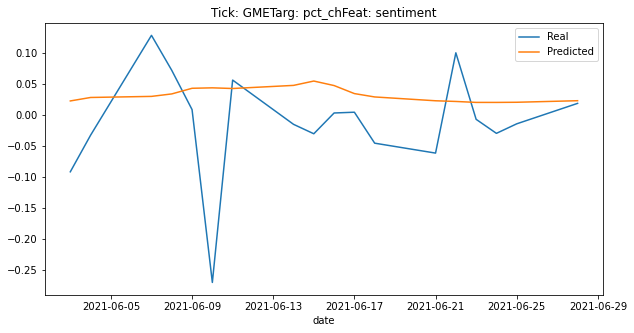

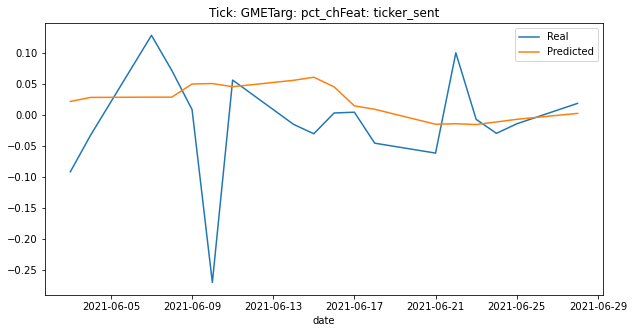

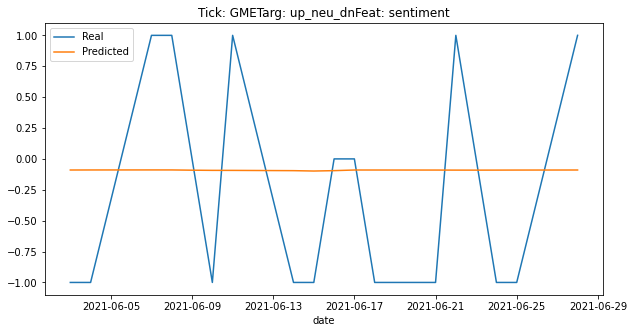

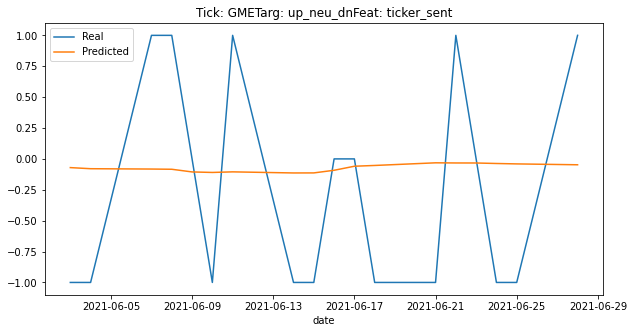

In [22]:
for cur_targ in targ_list:
#         feat_list = [cur_tick + count_sufx] + feat_tmplt # feature list based on ticker
    for cur_feat in feat_list:
        title = 'Tick: ' + cur_tick + 'Targ: ' + cur_targ  + 'Feat: ' + cur_feat
        fname = cur_tick + '_' + cur_targ  + '_' + cur_feat + 'png'
        cur_loss = run_lstm(ml_df, cur_feat, cur_targ, fname , title)
        result_df.loc[len(result_df.index)] = [cur_tick, cur_targ, cur_feat, cur_loss]
        
csv_fname = cur_tick + '_rslt.csv'
result_df.to_csv(csv_fname)